In [101]:
#Load packages
library(ggplot2)
library(ISLR)
library(MASS)
library(lmtest)
library(sandwich)
library(tree)
library(randomForest)
library(rpart)
library(rpart.plot)
library(Metrics)
library(gbm)
library(xgboost)
library(leaps)
library(corrplot)
library(caret)
library(e1071)
library(DiagrammeR)

ERROR: Error in library(DiagrammeR): there is no package called ‘DiagrammeR’


In [71]:
#Load datafiles
#load(file = 'data/newdata/trainData.RData')
#load(file = 'data/newdata/testData.RData')
load(file = 'data/newdata/trainData2.RData')
load(file = 'data/newdata/testData2.RData')

In [72]:
dim(trainData)
dim(testData)

[1] 5626   28

[1] 1407   28

In [85]:
skewness(trainData$SQUARE_FEET)

[1] 2.704915

In [87]:
is.numeric(trainData$BEDS)

[1] TRUE

In [73]:
#Drop community_no
trainData = within(trainData, rm('community_no'))
testData = within(testData, rm('community_no'))

In [74]:
#Remove baseline variables:
trainData = within(trainData, rm('PROPERTY_TYPE.Condo/Co-op','NeighRich.1'))
testData = within(testData, rm('PROPERTY_TYPE.Condo/Co-op','NeighRich.1'))

In [75]:
#Fixing some naming issue:
colnames(trainData)[colnames(trainData)=='PROPERTY_TYPE.Single Family Residential'] = "PROPERTY_TYPE.Single.Family.Residential"
colnames(testData)[colnames(testData)=='PROPERTY_TYPE.Single Family Residential'] = "PROPERTY_TYPE.Single.Family.Residential"




In [76]:
# Split the training data further 
set.seed(123)
train = sample(dim(trainData)[1], dim(trainData)[1]*0.9 )
train_set = trainData[train,]
validation_set = trainData[-train,]


In [77]:
dim(train_set)
dim(validation_set)

[1] 5063   25

[1] 563  25

In [78]:
names(train_set)

[1] "PRICE"                                  
 [2] "BEDS"                                   
 [3] "BATHS"                                  
 [4] "SQUARE_FEET"                            
 [5] "LATITUDE"                               
 [6] "LONGITUDE"                              
 [7] "min_dist_cta"                           
 [8] "num_cta_1mile"                          
 [9] "crime_per_1000"                         
[10] "life_exp_2010"                          
[11] "unemployment"                           
[12] "perc_housing_crowded"                   
[13] "perc_household_below_poverty"           
[14] "perc_16plus_unempl"                     
[15] "perc_25plus_no_school_diploma"          
[16] "perc_under18_over64"                    
[17] "income_per_capite"                      
[18] "hardship_index"                         
[19] "percent_level1_school"                  
[20] "percent_level2_school"                  
[21] "HouseAge"                               
[22] "PROPERTY_TYPE.Single.Family.Residential"
[23] "PROPERTY_TYPE.Townhouse"                
[24] "NeighRich.0"                            
[25] "NeighRich.2"

# Fit Regression Trees

In [79]:
#Using rpart package
#This differs from the tree function in S mainly in its handling of surrogate variables. In most
#details it follows Breiman et. al (1984) quite closely. R package tree provides a re-implementation
#of tree.

tree2 = rpart(PRICE ~., data = train_set)

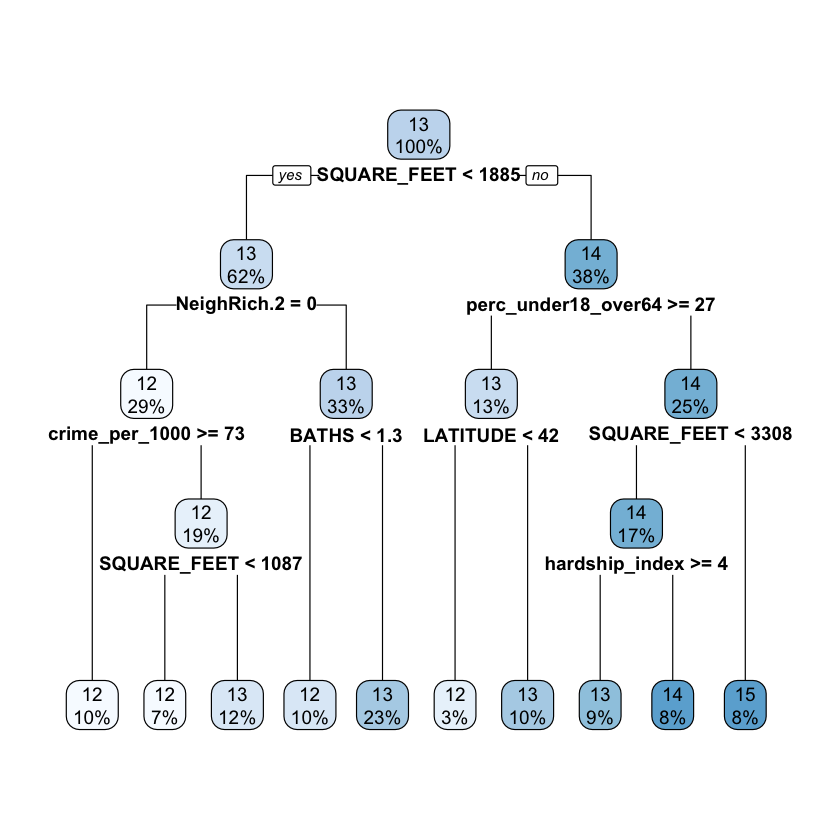

In [80]:
rpart.plot(tree2)

[1] "RMSE"


[1] 0.4272724

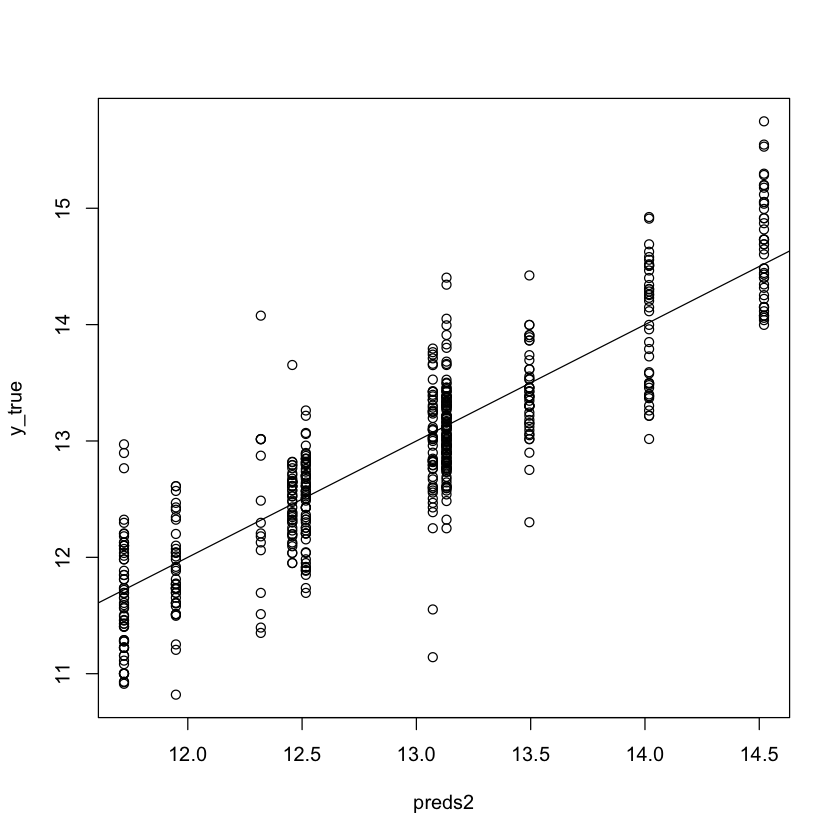

In [81]:
#Check prediction:
y_true = validation_set$PRICE
preds2 = predict(tree2, newdata=validation_set)
plot(preds2, y_true)
abline(0,1)
print('RMSE')
rmse(y_true, preds2)


# Try Random Forests

In [146]:
set.seed(123)
bag.chicago = randomForest(PRICE~., data = trainData, ntree = 500, importance = TRUE)
bag.chicago


Call:
 randomForest(formula = PRICE ~ ., data = trainData, ntree = 500,      importance = TRUE) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 8

          Mean of squared residuals: 0.0596295
                    % Var explained: 92.38

[1] "RMSE"


[1] 0.2395867

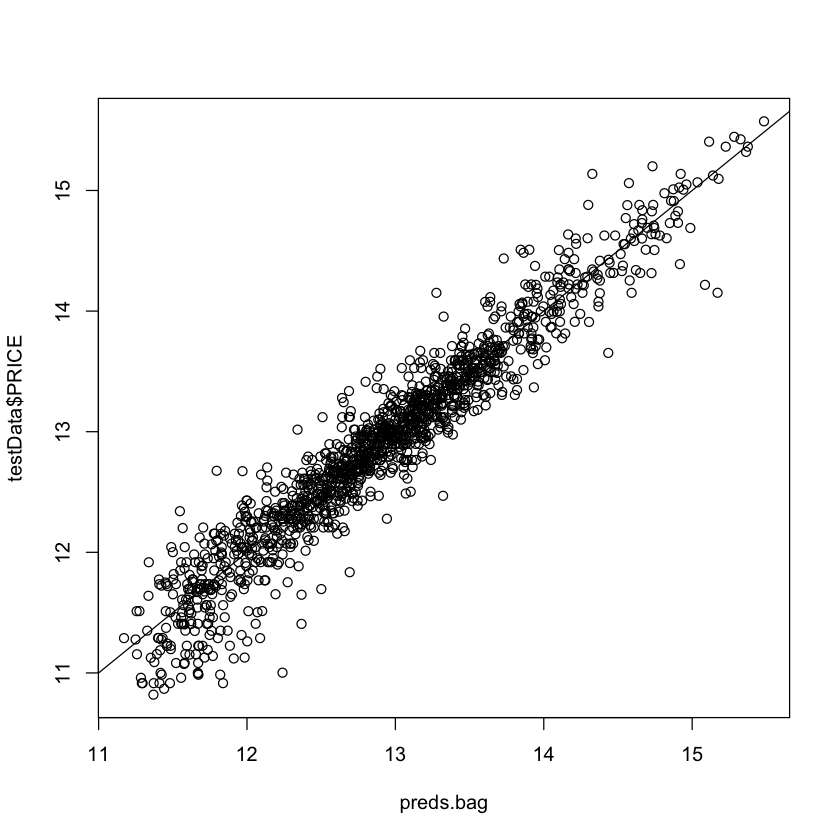

In [147]:
preds.bag = predict(bag.chicago, newdata = testData)
plot(preds.bag, testData$PRICE)
abline(0,1)
print('RMSE')
rmse(testData$PRICE, preds.bag)


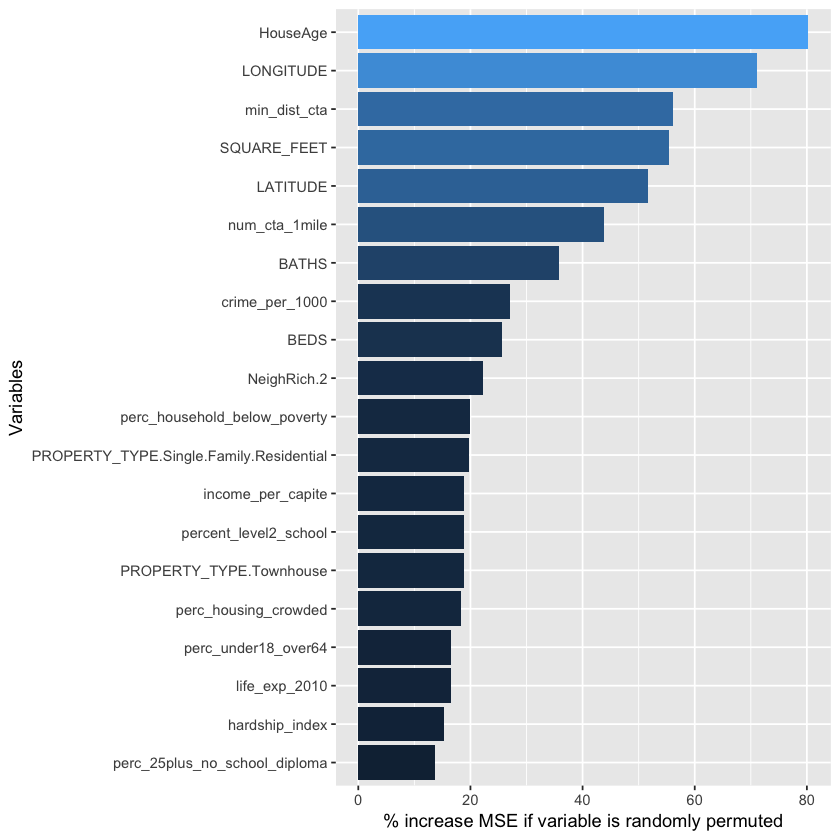

In [148]:
imp_RF2 = importance(bag.chicago)
imp_DF2 = data.frame(Variables = row.names(imp_RF2), MSE = imp_RF2[,1])
imp_DF2 = imp_DF2[order(imp_DF2$MSE, decreasing = TRUE),]

ggplot(imp_DF2[1:20,], aes(x=reorder(Variables, MSE), y=MSE, fill = MSE)) +
    geom_bar(stat = 'identity') + coord_flip() +
    labs(x = 'Variables', y= '% increase MSE if variable is randomly permuted') +
    theme(legend.position="none")

In [ ]:
#varImpPlot(bag.chicago2)

# Try Boosting

In [93]:
train_control_gbm = trainControl(method = "repeatedcv", number = 5, repeats = 5, 
    verboseIter = FALSE, allowParallel = TRUE)

gbm.chicago = train(PRICE ~ ., method = "gbm", metric = "RMSE", maximize = FALSE, 
    trControl = train_control_gbm, tuneGrid = expand.grid(n.trees = (4:10) * 
        50, interaction.depth = c(6), shrinkage = c(0.05), n.minobsinnode = c(10)), 
    data = train_set, verbose = FALSE)



In [94]:
gbm.chicago

Stochastic Gradient Boosting 

5063 samples
  24 predictor

No pre-processing
Resampling: Cross-Validated (5 fold, repeated 5 times) 
Summary of sample sizes: 4051, 4050, 4050, 4051, 4050, 4050, ... 
Resampling results across tuning parameters:

  n.trees  RMSE       Rsquared 
  200      0.2641141  0.9101429
  250      0.2607428  0.9123871
  300      0.2580001  0.9142039
  350      0.2562541  0.9153347
  400      0.2548054  0.9162831
  450      0.2534371  0.9171875
  500      0.2524499  0.9178330

Tuning parameter 'interaction.depth' was held constant at a value of 6

Tuning parameter 'shrinkage' was held constant at a value of 0.05

Tuning parameter 'n.minobsinnode' was held constant at a value of 10
RMSE was used to select the optimal model using  the smallest value.
The final values used for the model were n.trees = 500, interaction.depth =
 6, shrinkage = 0.05 and n.minobsinnode = 10.

In [95]:
## Predictions
preds.gbm = predict(gbm.chicago, newdata = validation_set)
rmse(y_true, preds.gbm)

[1] 0.2476982

# Try XGBOOST

In [138]:
set.seed(123)
xgb.chicago1 = xgboost(data = as.matrix(trainData[, -1]), nfold = 5, label = as.matrix(trainData$PRICE), 
    nrounds = 2200, verbose = FALSE, objective = "reg:linear", eval_metric = "rmse", 
    nthread = 8, eta = 0.05, gamma = 0, max_depth = 6, min_child_weight = 2, 
    subsample = 1, colsample_bytree = 1)

In [139]:
print(xgb.chicago1)

##### xgb.Booster
raw: 5.9 Mb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, nfold = 5, objective = "reg:linear", 
    eval_metric = "rmse", nthread = 8, eta = 0.05, gamma = 0, 
    max_depth = 6, min_child_weight = 2, subsample = 1, colsample_bytree = 1)
params (as set within xgb.train):
  nfold = "5", objective = "reg:linear", eval_metric = "rmse", nthread = "8", eta = "0.05", gamma = "0", max_depth = "6", min_child_weight = "2", subsample = "1", colsample_bytree = "1", silent = "1"
xgb.attributes:
  niter
callbacks:
  cb.evaluation.log()
# of features: 24 
niter: 2200
nfeatures : 24 
evaluation_log:
    iter train_rmse
       1  11.850999
       2  11.260092
---                
    2199   0.048183
    2200  

In [149]:
#preds.xgb1 = predict(xgb.chicago1, newdata = as.matrix(validation_set[, -1]))
#rmse(y_true, preds.xgb1)


In [140]:
imp_xgb = xgb.importance (feature_names = colnames(trainData[,-1]),model = xgb.chicago1)

Frequency: The number of times a feature is used to split the data across all trees.


Cover: The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits. 


Gain: The average training loss reduction gained when using a feature for splitting.

In [141]:
imp_xgb[1:20,]

Feature,Gain,Cover,Frequency
SQUARE_FEET,0.341868543,0.1478433767,0.1766859587
BATHS,0.194450527,0.0333401429,0.0514720684
NeighRich.2,0.135212380,0.0008802145,0.0005410166
income_per_capite,0.087213667,0.0061628331,0.0055234021
perc_under18_over64,0.059894946,0.0072802338,0.0115123301
LATITUDE,0.042506615,0.2104931545,0.1659411173
HouseAge,0.038533102,0.0899951183,0.1155385003
LONGITUDE,0.024418080,0.2240920489,0.1543407146
min_dist_cta,0.015428387,0.1734113289,0.1539255159
hardship_index,0.013710290,0.0030896176,0.0019753397


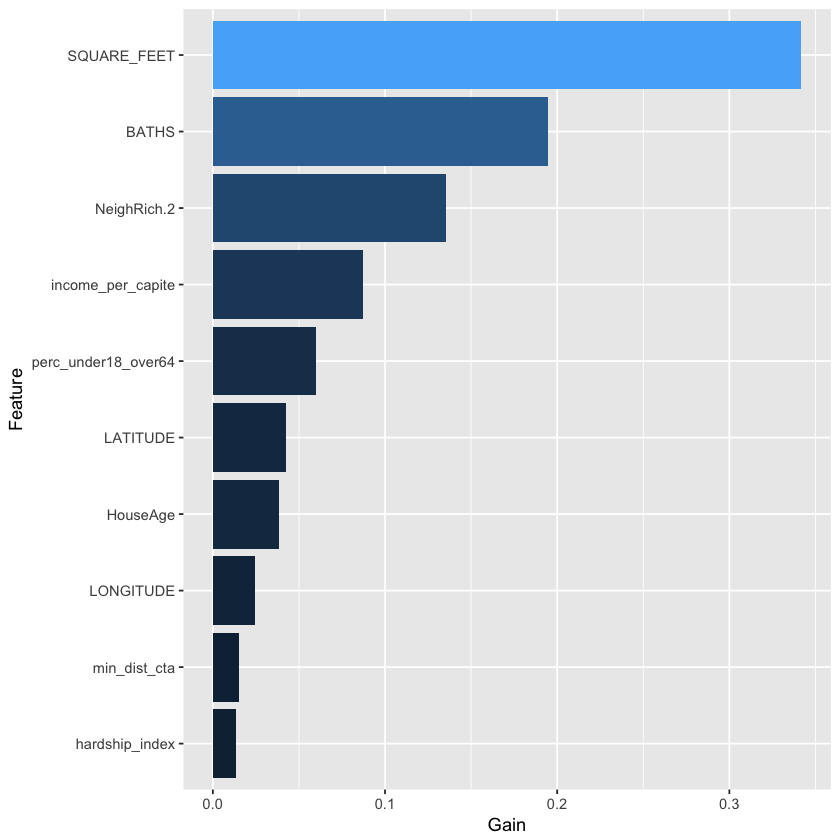

In [142]:
ggplot(imp_xgb[1:10,], aes(x=reorder(Feature, Gain), y=Gain, fill = Gain)) +
    geom_bar(stat = 'identity') + coord_flip() +
    labs(x = 'Feature', y= 'Gain') +
    theme(legend.position="none")

#### Fix multicollinearity

In [143]:
cor(trainData$income_per_capite, trainData$perc_under18_over64)
cor(trainData$income_per_capite, trainData$hardship_index)
cor(trainData$income_per_capite, trainData$min_dist_cta)

[1] -0.7312333

[1] -0.8343022

[1] -0.525136

In [144]:
summary(lm(income_per_capite~ perc_under18_over64 + hardship_index, data = trainData))


Call:
lm(formula = income_per_capite ~ perc_under18_over64 + hardship_index, 
    data = trainData)

Residuals:
   Min     1Q Median     3Q    Max 
-18759 -10571  -2871   7342  27722 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)         77579.26     779.08   99.58   <2e-16 ***
perc_under18_over64  -520.83      34.87  -14.94   <2e-16 ***
hardship_index       -717.12      12.43  -57.68   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 13390 on 5623 degrees of freedom
Multiple R-squared:  0.7077,	Adjusted R-squared:  0.7076 
F-statistic:  6806 on 2 and 5623 DF,  p-value: < 2.2e-16


In [131]:
#Drop perc_under18_over64 + hardship_index
trainData2 = data.frame(trainData)
testData2 = data.frame(testData)
trainData2 = within(trainData2, rm('perc_under18_over64', 'hardship_index'))
testData2 = within(testData2, rm('perc_under18_over64', 'hardship_index'))

In [133]:
set.seed(123)
xgb.chicago3 = xgboost(data = as.matrix(trainData2[, -1]), nfold = 5, label = as.matrix(trainData2$PRICE), 
    nrounds = 2200, verbose = FALSE, objective = "reg:linear", eval_metric = "rmse", 
    nthread = 8, eta = 0.05, gamma = 0, max_depth = 6, min_child_weight = 2, 
    subsample = 1, colsample_bytree = 1)

In [134]:
print(xgb.chicago3)

##### xgb.Booster
raw: 5.9 Mb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, nfold = 5, objective = "reg:linear", 
    eval_metric = "rmse", nthread = 8, eta = 0.05, gamma = 0, 
    max_depth = 6, min_child_weight = 2, subsample = 1, colsample_bytree = 1)
params (as set within xgb.train):
  nfold = "5", objective = "reg:linear", eval_metric = "rmse", nthread = "8", eta = "0.05", gamma = "0", max_depth = "6", min_child_weight = "2", subsample = "1", colsample_bytree = "1", silent = "1"
xgb.attributes:
  niter
callbacks:
  cb.evaluation.log()
# of features: 22 
niter: 2200
nfeatures : 22 
evaluation_log:
    iter train_rmse
       1  11.851012
       2  11.260119
---                
    2199   0.048919
    2200  

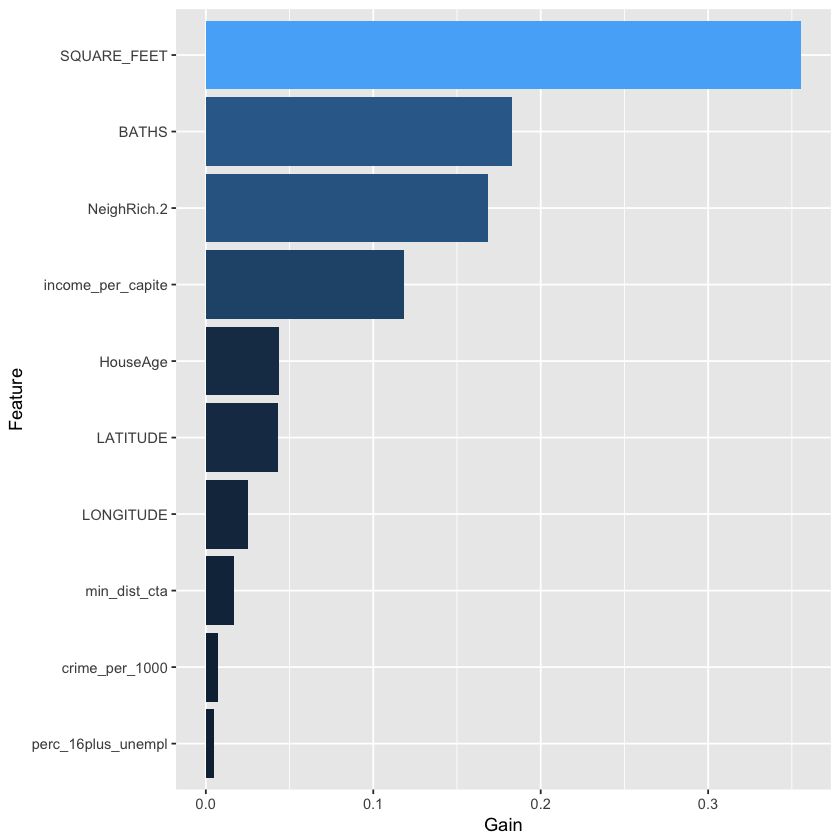

In [137]:
imp_xgb2 = xgb.importance (feature_names = colnames(trainData2[,-1]),model = xgb.chicago3)
ggplot(imp_xgb2[1:10,], aes(x=reorder(Feature, Gain), y=Gain, fill = Gain)) +
    geom_bar(stat = 'identity') + coord_flip() +
    labs(x = 'Feature', y= 'Gain') +
    theme(legend.position="none")

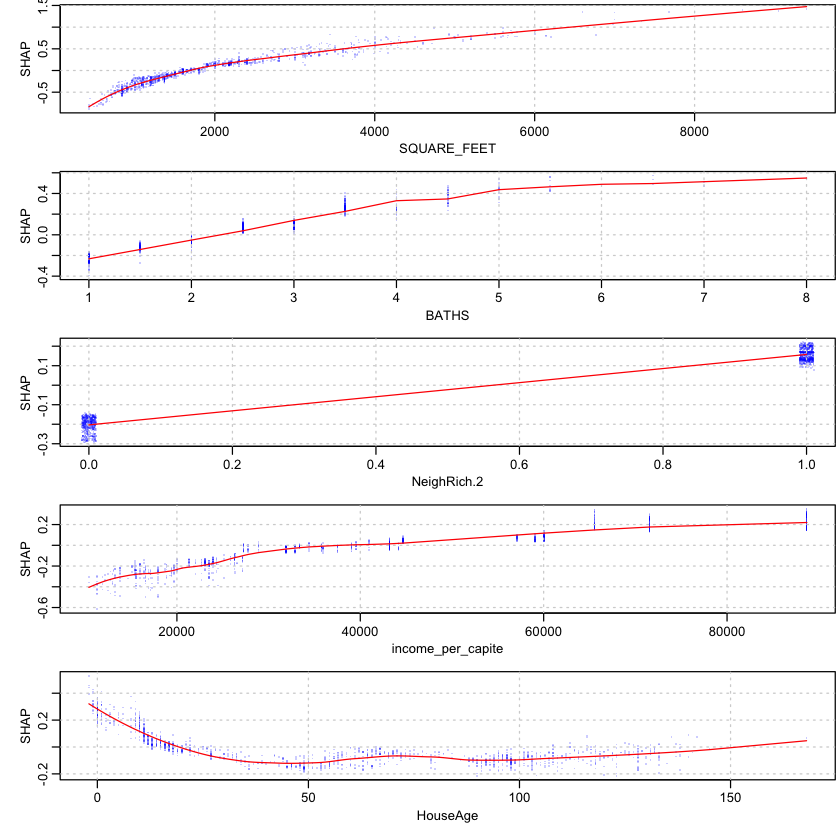

In [136]:
plot.window(c(0, 20), c(0,100))
xgb.plot.shap(as.matrix(testData2[, -1]), model = xgb.chicago3, top_n = 5)

# Compare Prediction Scores with testData

In [150]:
#Predict test set
test_preds.xgb1 = predict(xgb.chicago1, newdata = as.matrix(testData[, -1]))
rmse(testData$PRICE, test_preds.xgb1)

[1] 0.2363007

In [151]:
test_preds.xgb3 = predict(xgb.chicago3, newdata = as.matrix(testData2[, -1]))
rmse(testData2$PRICE, test_preds.xgb3)

[1] 0.2374197

In [152]:
test_preds.RF = predict(bag.chicago, newdata = testData)
rmse(testData$PRICE, test_preds.RF)

[1] 0.2395867